In [0]:
# データの読み込み
from sklearn.datasets import load_digits

digits = load_digits()

import numpy as np
import matplotlib.pyplot as plt

X = digits.data
y = digits.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

6


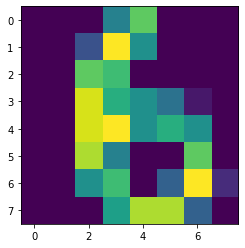

In [2]:
plt.imshow(X_test[0].reshape(8, 8))
print(y_test[0])

9


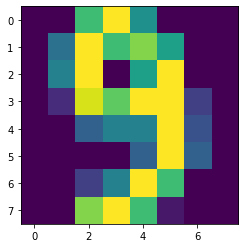

In [3]:
plt.imshow(X_test[1].reshape(8, 8))
print(y_test[1])

In [4]:
# sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.predict(X_test[:2])) # X_test[0]とX_test[1]を推論

0.9733333333333334
[6 9]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [5]:
# keras
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
# sparse_categorical_crossentropy vs categorical_crossentropy
# https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=100)
_, acc = model.evaluate(X_test, y_test)
print(acc)
pred = model.predict(X_test[:2])
print(np.argmax(pred, axis=1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________
Train on 1347 samples
Epoch 1/100
1347/1347 [==============================] - 0s 217us/sample - loss: 2.2608 - acc: 0.4959
Epoch 2/100
1347/1347 [==============================] - 0s 54us/sample - loss: 0.3856 - acc: 0.8834
Epoch 3/100
1347/1347 [==============================] - 0s 53us/sample - loss

In [0]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [0]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    
    self.x = None
    self.original_x_shape = None

    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x

    out = np.dot(self.x, self.W) + self.b
    return out

  def backword(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    # print("affine dx before:" + str(dx.shape))
    dx = dx.reshape(*self.original_x_shape)
    # print("affine dx after:" + str(dx.shape))
    return dx

class Relu:
  def __init__(self):
    self.mask = None
  
  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backword(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backword(self, dout):
    dx = dout * self.out * (1 - self.out)
    return dx

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backword(self, dout=1):
    # doutを使っていない
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      # print("same size")
      dx = (self.y - self.t) / batch_size
    else:
      # print("not same size")
      # print("t size:" + str(self.t.size))
      # print("x size:" + str(self.y.size))
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx

In [0]:
import numpy as np
from collections import OrderedDict

class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relue1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.lastLayer.backword(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backword(dout)

    grads = {}
    grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grads

In [17]:
network = TwoLayerNet(input_size=64, hidden_size=128, output_size=10)

iters_num = 500
train_size = X_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = X_train[batch_mask]
    print(i)
    t_batch = y_train[batch_mask]
    
    # 勾配
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % 10 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("====train acc: " + str(train_acc), "test acc: " + str(test_acc), "====")

0
====train acc: 0.214550853749072 test acc: 0.19777777777777777 ====
1
2
3
4
5
6
7
8
9
10
====train acc: 0.36525612472160357 test acc: 0.3333333333333333 ====
11
12
13
14
15
16
17
18
19
20
====train acc: 0.23311061618411286 test acc: 0.20666666666666667 ====
21
22
23
24
25
26
27
28
29
30
====train acc: 0.5701559020044543 test acc: 0.5088888888888888 ====
31
32
33
34
35
36
37
38
39
40
====train acc: 0.5530809205642168 test acc: 0.5577777777777778 ====
41
42
43
44
45
46
47
48
49
50
====train acc: 0.5478841870824054 test acc: 0.5244444444444445 ====
51
52
53
54
55
56
57
58
59
60
====train acc: 0.726800296956199 test acc: 0.7288888888888889 ====
61
62
63
64
65
66
67
68
69
70
====train acc: 0.8648849294729027 test acc: 0.8755555555555555 ====
71
72
73
74
75
76
77
78
79
80
====train acc: 0.7401633259094283 test acc: 0.7644444444444445 ====
81
82
83
84
85
86
87
88
89
90
====train acc: 0.8507795100222717 test acc: 0.8533333333333334 ====
91
92
93
94
95
96
97
98
99
100
====train acc: 0.8426132

In [19]:
pred = network.predict(X_test[:2])
print(np.argmax(pred, axis=1))

[6 9]


In [15]:
np.argmax(model.predict(X_test[:2]), axis=1)

array([6, 9])